# Preparação do ambiente

## Bibliotecas

In [1]:
import configparser
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import string

from cryptography.fernet import Fernet
from redminelib import Redmine
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tabulate import tabulate
from tqdm.auto import tqdm
from unicodedata import normalize

In [2]:
pd.options.mode.chained_assignment = None

## Constantes e funções auxiliares

In [3]:
NULL_STRING = '#NULLO#'
FILE_SAMPLES = '../datasets/label_issues/20240423/results/samples.parquet'
FILE_SAMPLES_RESULTS = '../datasets/label_issues/20240423/results/samples_results.parquet'
FILE_LABELS = '../datasets/label_issues/20240423/results/issues.csv'
FILE_CREDS = '../creds.ini'
FILE_RESULTS_REPORT = '../datasets/label_issues/20240423/results/report.xlsx'
FILE_ITEMS = '../datasets/label_issues/20240423/results/items.parquet'

In [4]:
creds = configparser.ConfigParser()
creds.read(FILE_CREDS)

redmine_url = creds['FISCALIZA']['redmine_url']

refkey = creds['ID']['refkey']
username = creds['ID']['username']
password = creds['ID']['password']

refkey = Fernet(refkey)
username = bytes(username,'utf-8')
password = bytes(password,'utf-8')

username = refkey.decrypt(username).decode('utf-8')
password = refkey.decrypt(password).decode('utf-8')

In [5]:
def parse_issue(issue):
    issue_attrs = ['id', 'tracker', 'status', 'closed_on', 'subject', 'assigned_to']
    issue_results = {}
    for attr in issue_attrs:
        issue_results[attr] = str(issue[attr])

    custom_fields = list(issue.custom_fields.values_list())
    for _, field, value in custom_fields:
        issue_results[field] = str(value)

    return issue_results

In [6]:
def plot_donut(labels,values,title,startangle=30, colors=None):
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw=dict(aspect="equal"))
    
    wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), colors=colors, startangle=startangle)
    
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props,
              zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    label_completed = '{:.2f}%'.format(values[0]/values.sum()*100)
    ax.annotate(label_completed,xy=(0,0),horizontalalignment='center', verticalalignment='center')
    
    ax.set_title(title)
    plt.show()

In [7]:
def clean_text(doc, return_tokens=False):

    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(string.punctuation))
    
    # stopwords específicas do domínio
    # stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver'])
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", relevante para o domínio
    # primeira rodada de classificação demonstrou que não foi uma boa escolha
    # stop_words.remove('sem')
    
    doc = doc.lower()
    doc = normalize('NFKD', doc).encode('ASCII', 'ignore').decode('ASCII')

    tokens = [token for token in word_tokenize(doc, language='portuguese') if token not in stop_words]
    if return_tokens:
        return tokens
    else:
        return ' '.join(tokens)

# Carga e prepação dos dados

## Carga da amostra

In [8]:
df_samples = pd.read_parquet(FILE_SAMPLES)

columns_to_keep = ['marketplace','nome','desc','Título']
df_samples = df_samples[columns_to_keep]

columns_to_keep = ['marketplace','nome','desc','subject']
df_samples.columns = columns_to_keep

df_samples

,marketplace,nome,desc,subject
0,mercadolivre,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,LABEL_PACP_2024_00000001
1,magalu,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,LABEL_PACP_2024_00000002
2,mercadolivre,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,LABEL_PACP_2024_00000003
3,amazon,"Mini rede sem fio, placa de rede sem fio USB 3...",,LABEL_PACP_2024_00000004
4,magalu,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",LABEL_PACP_2024_00000005
...,...,...,...,...
21511,amazon,CAIXA ACUSTICA PCX6500,,LABEL_PACP_2024_00021512
21512,amazon,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",LABEL_PACP_2024_00021513
21513,amazon,Avantree Medley Clear - Fones de ouvido sem fi...,,LABEL_PACP_2024_00021514
21514,amazon,"Hilitand Adaptador sem fio, placa de rede sem ...",,LABEL_PACP_2024_00021515


## Carga dos dados extraídos

In [9]:
df_issues = pd.read_parquet(FILE_SAMPLES_RESULTS)
df_closed_issues = df_issues[df_issues['status']=='Concluída']
df_open_issues = df_issues[df_issues['status']!='Concluída']

last_closed = df_issues['closed_on'].max()

map_status = {'Concluída': 'Fechada', 'Responder pesquisa': 'Aberta'}
df_resumo = df_issues[['id','status']]
df_resumo['status'] = df_resumo['status'].map(map_status)

df_resumo = df_resumo[['id','status']].groupby('status').count()
df_resumo.loc['Total'] = df_resumo.sum()
print(tabulate(df_resumo))
print(f'Última atualização em: {last_closed} UTC')

df_issues

-------  -----
Aberta   17988
Fechada   3528
Total    21516
-------  -----
Última atualização em: 2024-05-08 13:36:38 UTC


,id,tracker,status,closed_on,subject,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
0,125707,Rotulagem de Dados,Concluída,2024-04-29 14:36:47,LABEL_PACP_2024_00021516,Maxwel de Souza Freitas,UO021,1,1,Sim,Sim,Sim,Sim,Drone
1,125708,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021505,Maxwel de Souza Freitas,UO021,,,,,,,
2,125709,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021506,Maxwel de Souza Freitas,UO021,,,,,,,
3,125710,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021507,Maxwel de Souza Freitas,UO021,,,,,,,
4,125711,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021508,Maxwel de Souza Freitas,UO021,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21511,147227,Rotulagem de Dados,Concluída,2024-05-06 14:42:10,LABEL_PACP_2024_00002556,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
21512,147228,Rotulagem de Dados,Concluída,2024-04-29 19:12:23,LABEL_PACP_2024_00002557,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
21513,147229,Rotulagem de Dados,Concluída,2024-05-06 14:40:28,LABEL_PACP_2024_00002558,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
21514,147230,Rotulagem de Dados,Concluída,2024-04-29 19:01:56,LABEL_PACP_2024_00002559,Cesar Alexandre Parazi,FIGF,1,0,Não,Não,Não,Não,Outro tipo/categoria (não listada acima)


## Atualização dos dados do Fiscaliza

**Atenção**
Essa operação pode demorar até 10 minutos para ser executada

In [10]:
%%time
# redmine = Redmine(redmine_url,key=redmine_api_key)
redmine = Redmine(redmine_url, username=username, password=password)

# filter issues closed from the last closed_on day in actual dataframe 
last_closed_on = df_issues.closed_on.max().strftime('%Y-%m-%d')
last_closed_on = f'>={last_closed_on}'
closed_issues = redmine.issue.filter(project_id=184, status_id='closed', closed_on=last_closed_on)

# uncomment following line to get all closed issues
closed_issues = redmine.issue.filter(project_id=184, status_id='closed')

# uncomment following line to get all issues
# closed_issues = redmine.issue.filter(project_id=184, status_id='*')

df_closed_issues = pd.DataFrame([parse_issue(issue) for issue in closed_issues])
df_closed_issues['closed_on'] = pd.to_datetime(df_closed_issues['closed_on'],errors='coerce')

df_issues = pd.concat([df_issues, df_closed_issues])
df_issues = df_issues.drop_duplicates(subset='subject',keep='last')
df_issues = df_issues.sort_values(by='id').reset_index(drop=True)


df_issues.to_parquet(FILE_SAMPLES_RESULTS)

map_status = {'Concluída': 'Fechada', 'Responder pesquisa': 'Aberta'}
df_resumo = df_issues[['id','status']]
df_resumo['status'] = df_resumo['status'].map(map_status)
df_resumo = df_resumo.groupby('status').count()
df_resumo.loc['Total'] = df_resumo.sum()

print('Total de tarefas atualizadas:',len(df_closed_issues),'\n')
print(tabulate(df_resumo))
print(f'Última atualização em: {last_closed} UTC')

Total de tarefas atualizadas: 4351 

-------  -----
Aberta   17164
Fechada   4352
Total    21516
-------  -----
Última atualização em: 2024-05-08 13:36:38 UTC
CPU times: total: 1 s
Wall time: 2min 7s


## Junção dos dados

In [11]:
df_labels = df_samples.merge(df_issues,on='subject', how='left')
df_labels

,marketplace,nome,desc,subject,id,tracker,status,closed_on,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
0,mercadolivre,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,LABEL_PACP_2024_00000001,125728,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
1,magalu,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,LABEL_PACP_2024_00000002,125729,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
2,mercadolivre,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,LABEL_PACP_2024_00000003,125730,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
3,amazon,"Mini rede sem fio, placa de rede sem fio USB 3...",,LABEL_PACP_2024_00000004,125731,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
4,magalu,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",LABEL_PACP_2024_00000005,125732,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21511,amazon,CAIXA ACUSTICA PCX6500,,LABEL_PACP_2024_00021512,125715,Rotulagem de Dados,Concluída,2024-04-29 18:56:17,Maxwel de Souza Freitas,UO021,0,1,Anúncio não possui descrição,Anúncio não possui descrição,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
21512,amazon,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",LABEL_PACP_2024_00021513,125716,Rotulagem de Dados,Concluída,2024-04-29 19:37:05,Maxwel de Souza Freitas,UO021,1,1,Sim,Sim,Não,Não,Outro tipo/categoria (não listada acima)
21513,amazon,Avantree Medley Clear - Fones de ouvido sem fi...,,LABEL_PACP_2024_00021514,125717,Rotulagem de Dados,Concluída,2024-04-29 18:42:42,Maxwel de Souza Freitas,UO021,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
21514,amazon,"Hilitand Adaptador sem fio, placa de rede sem ...",,LABEL_PACP_2024_00021515,125718,Rotulagem de Dados,Concluída,2024-04-29 18:41:24,Maxwel de Souza Freitas,UO021,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)


# Análise

## Acompanhamento da execução

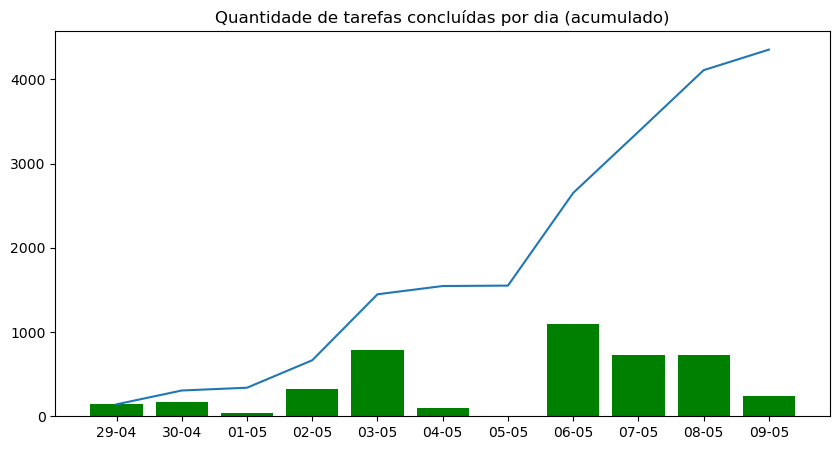

In [12]:
df_closed_on_date = df_labels[~df_labels['closed_on'].isna()][['closed_on','id']]
df_closed_on_date['closed_on'] = df_closed_on_date['closed_on'].dt.date
df_closed_on_date = df_closed_on_date.groupby('closed_on',as_index=False).count()
df_closed_on_date['acc'] = df_closed_on_date['id'].cumsum()

date = df_closed_on_date.iloc[:,0].values
date = df_closed_on_date.iloc[:,0].apply(lambda x: x.strftime('%d-%m'))

closed = df_closed_on_date.iloc[:,1].values
closed_acc = df_closed_on_date.iloc[:,2].values


fig,ax = plt.subplots(figsize=(10,5))
ax.plot(date,closed_acc)
ax.bar(date,closed,color='green')
ax.set_title('Quantidade de tarefas concluídas por dia (acumulado)')
plt.show()

In [13]:
df_fiscal = df_labels[df_labels['assigned_to']!='Maxwel de Souza Freitas']
df_fiscal = df_fiscal.pivot_table(index=['assigned_to', 'Unidade de Lotação'],columns='status',values='id',aggfunc='count')
df_fiscal = df_fiscal.fillna(0).astype('int')
df_fiscal['% Conclusão'] = df_fiscal['Concluída']/(df_fiscal.sum(axis=1))
df_fiscal = df_fiscal.sort_values(by='% Conclusão',ascending=False)
df_fiscal = df_fiscal.reset_index()

df_fiscal.columns = ['Fiscal', 'Unidade de Lotação', 'Concluída', 'Aberta', '% Conclusão']
df_fiscal

,Fiscal,Unidade de Lotação,Concluída,Aberta,% Conclusão
0,João Luis Alves Tavares,UO021,1024,0,1.000000
1,José Luciano da Silva,GR06,754,270,0.736328
2,Oppenheimer Herbert Hans Medeiros Queiroz,UO112,411,613,0.401367
3,Marcos Rogerio Gianotto,UO072,349,675,0.340820
4,Josias Pereira de Barcelos,UO021,305,719,0.297852
5,Darlan Lima Silva,UO073,295,729,0.288086
6,Williams Roosevelt Monjardim,UO021,273,751,0.266602
7,Aécio Ramires de Mesquita,UO071,229,795,0.223633
8,Thiago Antonio Alves,GR07,178,846,0.173828
9,Sebastião Rangel do Nascimento Silva,UO062,161,863,0.157227


In [14]:
df_unidade = df_labels[df_labels['assigned_to']!='Maxwel de Souza Freitas']
df_unidade = df_labels.pivot_table(index='Unidade de Lotação',columns='status',values='id',aggfunc='count')
df_unidade = df_unidade.fillna(0).astype('int')
df_unidade['% Conclusão'] = df_unidade['Concluída']/(df_unidade.sum(axis=1))
df_unidade = df_unidade.sort_values(by='% Conclusão',ascending=False)
df_unidade = df_unidade.reset_index()
df_unidade.columns = ['Unidade', 'Concluída', 'Aberta', '% Conclusão']
df_unidade

,Unidade,Concluída,Aberta,% Conclusão
0,GR06,754,270,0.736328
1,UO112,411,613,0.401367
2,UO021,1609,2499,0.391675
3,UO072,349,675,0.340820
4,UO073,295,729,0.288086
5,UO071,229,795,0.223633
6,UO062,161,863,0.157227
7,FIGF,150,874,0.146484
8,GR02,120,904,0.117188
9,GR05,96,928,0.093750


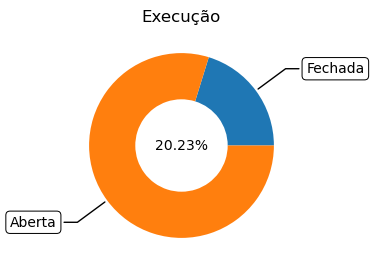

In [15]:
df_count = df_labels[['status','id']].groupby('status').count()
labels = [map_status[label] for label in df_count.index.values]
values = df_count.values.squeeze()
plot_donut(labels,values,'Execução',startangle=0)

In [16]:
with pd.ExcelWriter(FILE_RESULTS_REPORT) as writer:
    df_unidade.to_excel(writer, sheet_name='Unidade', index=False)
    df_fiscal.to_excel(writer, sheet_name='Fiscal', index=False)

## Preenchimento

Verificar se há incoerências no preenchimento, em especial nas perguntas sobre descrição. O campo do Fiscaliza que contém os dados do anúncio é denominado "Descrição" e pode confundir os fiscais durante a rotulagem.



In [17]:
df_labels[((df_labels['desc']==' ')
           &(df_labels['status']=='Concluída'))].pivot_table(
    index='Descrição identifica produto?',
    columns='Descrição bem elaborada?',
    values='id',aggfunc='count').fillna(0).astype('int')

Descrição bem elaborada?,Anúncio não possui descrição,Não,Sim
Descrição identifica produto?,,,
Anúncio não possui descrição,1535,1,0
Não,0,25,2
Sim,0,43,40


In [18]:
df_labels[((df_labels['desc']==' ')
           &(df_labels['status']=='Concluída')
           &(df_labels['Descrição bem elaborada?']=='Anúncio não possui descrição')
           &(df_labels['Descrição identifica produto?'].isin(['Sim','Não'])))]

,marketplace,nome,desc,subject,id,tracker,status,closed_on,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?


In [19]:
df_labels[((df_labels['desc']==' ')
           &(df_labels['status']=='Concluída')
           &(df_labels['Descrição bem elaborada?'].isin(['Sim','Não']))
           &(df_labels['Descrição identifica produto?'].isin(['Sim','Não'])))]

,marketplace,nome,desc,subject,id,tracker,status,closed_on,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
2035,amazon,Mini Caixa De Som Speaker Bluetooth Portátil A...,,LABEL_PACP_2024_00002036,127763,Rotulagem de Dados,Concluída,2024-04-29 19:28:00,Carlos Juliano Pott,GR05,1,1,Não,Não,Sim,Sim,Outro tipo/categoria (não listada acima)
2044,amazon,"Drone Quadcopter Dobrável, Modo Sem Cabeça 4K ...",,LABEL_PACP_2024_00002045,127772,Rotulagem de Dados,Concluída,2024-04-29 19:10:51,Carlos Juliano Pott,GR05,1,1,Não,Não,Sim,Sim,Drone
2558,amazon,CAIFENG Peças de reposição para reparo de cabo...,,LABEL_PACP_2024_00002559,147230,Rotulagem de Dados,Concluída,2024-04-29 19:01:56,Cesar Alexandre Parazi,FIGF,1,0,Não,Não,Não,Não,Outro tipo/categoria (não listada acima)
4554,amazon,eboxer-1 Cabo flexível conector dock porta de ...,,LABEL_PACP_2024_00004555,129770,Rotulagem de Dados,Concluída,2024-05-08 18:58:29,Eduardo Renato Rocha Brandão,GR02,1,1,Sim,Sim,Não,Não,Outro tipo/categoria (não listada acima)
5484,amazon,ASUS TUF Gaming Z790-Plus WiFi D4 LGA 1700 (In...,,LABEL_PACP_2024_00005485,130700,Rotulagem de Dados,Concluída,2024-05-03 10:42:45,João Luis Alves Tavares,UO021,1,1,Não,Não,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19452,amazon,"Transceptor de Rádio, Transceptor de Rádio de ...",,LABEL_PACP_2024_00019453,144668,Rotulagem de Dados,Concluída,2024-04-29 20:35:20,Thiago Antonio Alves,GR07,1,1,Não,Não,Não é possível afirmar,Não é possível afirmar,Transceptor de radiofrequência (VHF/UHF)
19453,amazon,4G LTE Mobile WiFi Hotspot Desbloqueado Dispos...,,LABEL_PACP_2024_00019454,144669,Rotulagem de Dados,Concluída,2024-04-29 20:34:25,Thiago Antonio Alves,GR07,1,1,Sim,Sim,Sim,Sim,Modem celular (2G/3G/4G/5G)
21294,amazon,SOLUSTRE 2 Unidades Adaptador Transmissor Usb ...,,LABEL_PACP_2024_00021295,146510,Rotulagem de Dados,Concluída,2024-05-08 19:04:38,Williams Roosevelt Monjardim,UO021,0,0,Não,Não,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
21303,amazon,Peças de reparo de substituição da capa da bat...,,LABEL_PACP_2024_00021304,146519,Rotulagem de Dados,Concluída,2024-05-08 18:49:46,Williams Roosevelt Monjardim,UO021,1,1,Não,Não,Não,Não,Outro tipo/categoria (não listada acima)


In [20]:
df = df_labels[((df_labels['É passível homologação?']=='Não')
                &(df_labels['É transmissor de RF'].isin(['Sim','Não é possível afirmar'])))]
df

,marketplace,nome,desc,subject,id,tracker,status,closed_on,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
4489,amazon,Conjunto de Controle Remoto de Distância de > ...,,LABEL_PACP_2024_00004490,129705,Rotulagem de Dados,Concluída,2024-05-09 14:04:06,Eduardo Renato Rocha Brandão,GR02,0,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Sim,Outro tipo/categoria (não listada acima)
9447,mercadolivre,"Sistema Wi-Fi mesh, Roteador Google Wifi snow ...",Com o access point da Google você pode interco...,LABEL_PACP_2024_00009448,134663,Rotulagem de Dados,Concluída,2024-05-09 00:42:52,Josias Pereira de Barcelos,UO021,0,1,Sim,Sim,Não,Sim,Roteador/repetidor/reforçador WiFi (2.4GHz/5.8...
9507,magalu,Auto Rádio Bluetooth USB FM RGB 4x60w Roadstar...,Visor grande e coloridoO RS-2750BR Plus possui...,LABEL_PACP_2024_00009508,134723,Rotulagem de Dados,Concluída,2024-05-08 23:44:01,Josias Pereira de Barcelos,UO021,0,1,Sim,Sim,Não,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
9515,amazon,K1 PRO com câme 4K Gimbal de 2 eixos Motor sem...,,LABEL_PACP_2024_00009516,134731,Rotulagem de Dados,Concluída,2024-05-08 20:35:23,Josias Pereira de Barcelos,UO021,0,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não é possível afirmar,Outro tipo/categoria (não listada acima)
9579,amazon,"GOSHYDA Barra de som sem fio, alto-falante Blu...",,LABEL_PACP_2024_00009580,134795,Rotulagem de Dados,Concluída,2024-05-08 01:18:24,Josias Pereira de Barcelos,UO021,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
13414,amazon,Panthaohuaes Para honra Magic3 Larrow Mitherbo...,1. PARTE DE SUBSTITUIÇÃO DO CABO FLEX CONNECT ...,LABEL_PACP_2024_00013415,138630,Rotulagem de Dados,Concluída,2024-05-08 16:43:55,Oppenheimer Herbert Hans Medeiros Queiroz,UO112,1,1,Sim,Não,Não,Não é possível afirmar,Outro tipo/categoria (não listada acima)
13477,amazon,"Transmissor e Receptor 5.0, Adaptador Sem Fio ...",,LABEL_PACP_2024_00013478,138693,Rotulagem de Dados,Concluída,2024-05-08 15:41:17,Oppenheimer Herbert Hans Medeiros Queiroz,UO112,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
13497,amazon,PartyKindom Mp3 Player De Carro Adaptador Sem ...,,LABEL_PACP_2024_00013498,138713,Rotulagem de Dados,Concluída,2024-05-08 15:20:48,Oppenheimer Herbert Hans Medeiros Queiroz,UO112,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
13528,amazon,alcance para roteador wi-fi - Cobre até 1200 M...,◕【Usando dupla frequência】Wifi Booster e ampl...,LABEL_PACP_2024_00013529,138744,Rotulagem de Dados,Concluída,2024-05-08 14:53:52,Oppenheimer Herbert Hans Medeiros Queiroz,UO112,1,1,Sim,Sim,Não,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
13679,mercadolivre,Módulo Transmissor De Fm Stéreo.,ATENÇÃO\nProduto destinado a pessoas com conhe...,LABEL_PACP_2024_00013680,138895,Rotulagem de Dados,Concluída,2024-05-07 15:09:10,Oppenheimer Herbert Hans Medeiros Queiroz,UO112,1,1,Sim,Sim,Não,Sim,Outro tipo/categoria (não listada acima)


In [21]:
for id in df.id:
    print(f'https://sistemas.anatel.gov.br/fiscaliza/issues/{id}')

https://sistemas.anatel.gov.br/fiscaliza/issues/129705
https://sistemas.anatel.gov.br/fiscaliza/issues/134663
https://sistemas.anatel.gov.br/fiscaliza/issues/134723
https://sistemas.anatel.gov.br/fiscaliza/issues/134731
https://sistemas.anatel.gov.br/fiscaliza/issues/134795
https://sistemas.anatel.gov.br/fiscaliza/issues/138630
https://sistemas.anatel.gov.br/fiscaliza/issues/138693
https://sistemas.anatel.gov.br/fiscaliza/issues/138713
https://sistemas.anatel.gov.br/fiscaliza/issues/138744
https://sistemas.anatel.gov.br/fiscaliza/issues/138895
https://sistemas.anatel.gov.br/fiscaliza/issues/138898
https://sistemas.anatel.gov.br/fiscaliza/issues/144496
https://sistemas.anatel.gov.br/fiscaliza/issues/144548
https://sistemas.anatel.gov.br/fiscaliza/issues/146460
https://sistemas.anatel.gov.br/fiscaliza/issues/146492
https://sistemas.anatel.gov.br/fiscaliza/issues/146561


## Resultados da rotulagem

In [22]:
columns_to_keep = ['id', 'nome', 'desc', 
                   'Título bem elaborado?', 'Título identifica o produto?',
                   'Descrição bem elaborada?', 'Descrição identifica produto?',
                   'É passível homologação?', 'É transmissor de RF', 'Qual o tipo do produto?']
df_items = df_labels[df_labels['status']=='Concluída'][columns_to_keep]
df_items = df_items.reset_index(drop=True)

map_columns = {'id': 'id', 'nome': 'nome', 'desc': 'desc', 
               'Título bem elaborado?': 'titulo_bem_elaborado', 'Título identifica o produto?': 'titulo_identifica_produto',
               'Descrição bem elaborada?': 'desc_bem_elaborada', 'Descrição identifica produto?': 'desc_identifica_produto',
               'É passível homologação?': 'passivel_homologacao', 'É transmissor de RF': 'transmissor_rf', 'Qual o tipo do produto?': 'tipo_produto'}
df_items.columns = df_items.columns.map(map_columns)

map_labels = {'Não': 0, 'Sim': 1, 'Não é possível afirmar': 3, 'Anúncio não possui descrição': 3}

df_items['titulo_bem_elaborado'] = df_items['titulo_bem_elaborado'].astype('int')
df_items['titulo_identifica_produto'] = df_items['titulo_identifica_produto'].astype('int')

df_items['desc_bem_elaborada'] = df_items['desc_bem_elaborada'].map(map_labels)
df_items['desc_identifica_produto'] = df_items['desc_identifica_produto'].map(map_labels)

df_items['passivel_homologacao'] = df_items['passivel_homologacao'].map(map_labels)
df_items['transmissor_rf'] = df_items['transmissor_rf'].map(map_labels)

df_items.to_parquet(FILE_ITEMS)

df_items

,id,nome,desc,titulo_bem_elaborado,titulo_identifica_produto,desc_bem_elaborada,desc_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto
0,126504,Controle Remoto Tv Samsung Smart,CONTROLE REMOTO COMPATIVEL PARA TV SMART SAMSU...,1,1,1,1,1,1,Transceptor de radiofrequência (VHF/UHF)
1,126505,Smartphone Redmi 9t Xiaomi Com Película E Capa...,#NULLO#,1,1,3,3,1,1,Smartphones
2,126506,Drone DJI Mini 3 Pro DJI RC-N1 (Sem tela) Fly ...,Drone DJI Mini 3 Pro DJI RC-N1 (Sem tela) Fly ...,1,1,1,1,1,1,Drone
3,126507,Smartphone Samsumg J5 Prime,"SMARTPHONE SAMSUMG J5 PRIME USADO, EXCELENTE E...",1,1,1,1,1,1,Smartphones
4,126508,"Tablet PC, 12 GB RAM 256 GB ROM US Plug 100-24...",,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
...,...,...,...,...,...,...,...,...,...,...
4347,125715,CAIXA ACUSTICA PCX6500,,0,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
4348,125716,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",1,1,1,1,0,0,Outro tipo/categoria (não listada acima)
4349,125717,Avantree Medley Clear - Fones de ouvido sem fi...,,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
4350,125718,"Hilitand Adaptador sem fio, placa de rede sem ...",,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)


In [23]:
df_items.pivot_table(index='titulo_bem_elaborado', columns='titulo_identifica_produto', values='id', aggfunc='count')

titulo_identifica_produto,0,1
titulo_bem_elaborado,,
0,481,955
1,94,2822


In [24]:
df_items.pivot_table(index='transmissor_rf', columns='passivel_homologacao', values='id', aggfunc='count').fillna(0).astype('int')

passivel_homologacao,0,1,3
transmissor_rf,,,
0,1644,488,17
1,13,1804,8
3,3,35,340


In [25]:
df_resumo_tipo = df_items.pivot_table(index='tipo_produto',columns=['passivel_homologacao','transmissor_rf'],values='id',aggfunc='count').fillna(0).astype('int')
df_resumo_tipo['total'] = df_resumo_tipo.sum(axis=1)
df_resumo_tipo = df_resumo_tipo.sort_values(by='total',ascending=False)

df_resumo_tipo

passivel_homologacao                                   0          1           \
transmissor_rf                                         0  1  3    0    1   3   
tipo_produto                                                                   
Outro tipo/categoria (não listada acima)            1444  3  3  107  161  24   
Transceptor de radiação restrita (2.4GHz/5.8GHz)       4  8  0   11  845   0   
Não é possível afirmar                               106  0  0    0   24   4   
Carregador para celular (inclusive powerbank)          4  0  0  221   61   3   
Smartphones                                            0  1  0   27  223   0   
Drone                                                  1  0  0   17  156   0   
Bateria de lítio para celular                          8  0  0   77   25   0   
Transceptor de radiofrequência (VHF/UHF)               0  0  0    0   99   0   
Roteador/repetidor/reforçador WiFi (2.4GHz/5.8GHz)     0  1  0    2   92   0   
TV Box/TV Stick                                        0  0  0    4   60   0   
Carregador ou fonte não destinada a celular           38  0  0    8    4   1   
Bateria não destinada a celular                       22  0  0    4    7   0   
Computador ou notebook                                 1  0  0    6   20   1   
Peça ou acessório com fio para computador             16  0  0    4    5   0   
Reforçador/repetidor de sinal de celular (2G/3G...     0  0  0    0   11   0   
Modem celular (2G/3G/4G/5G)                            0  0  0    0    9   0   
Bloqueador de sinal de celular (jammer/FlipperZ...     0  0  0    0    2   2   

passivel_homologacao                                 3         total  
transmissor_rf                                       0  1    3        
tipo_produto                                                          
Outro tipo/categoria (não listada acima)            10  2   84  1838  
Transceptor de radiação restrita (2.4GHz/5.8GHz)     0  4    0   872  
Não é possível afirmar                               4  1  252   391  
Carregador para celular (inclusive powerbank)        1  0    0   290  
Smartphones                                          0  0    0   251  
Drone                                                0  1    0   175  
Bateria de lítio para celular                        1  0    0   111  
Transceptor de radiofrequência (VHF/UHF)             0  0    1   100  
Roteador/repetidor/reforçador WiFi (2.4GHz/5.8GHz)   0  0    0    95  
TV Box/TV Stick                                      0  0    1    65  
Carregador ou fonte não destinada a celular          1  0    0    52  
Bateria não destinada a celular                      0  0    1    34  
Computador ou notebook                               0  0    0    28  
Peça ou acessório com fio para computador            0  0    1    26  
Reforçador/repetidor de sinal de celular (2G/3G...   0  0    0    11  
Modem celular (2G/3G/4G/5G)                          0  0    0     9  
Bloqueador de sinal de celular (jammer/FlipperZ...   0  0    0     4

### Títulos

In [26]:
df_items['doc'] = df_items['nome'].map(clean_text)
df_items['tokens'] = df_items['nome'].apply(lambda doc: clean_text(doc, return_tokens=True))
df_items

,id,nome,desc,titulo_bem_elaborado,titulo_identifica_produto,desc_bem_elaborada,desc_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto,doc,tokens
0,126504,Controle Remoto Tv Samsung Smart,CONTROLE REMOTO COMPATIVEL PARA TV SMART SAMSU...,1,1,1,1,1,1,Transceptor de radiofrequência (VHF/UHF),controle remoto tv samsung smart,"[controle, remoto, tv, samsung, smart]"
1,126505,Smartphone Redmi 9t Xiaomi Com Película E Capa...,#NULLO#,1,1,3,3,1,1,Smartphones,smartphone redmi 9t xiaomi pelicula capa seminovo,"[smartphone, redmi, 9t, xiaomi, pelicula, capa..."
2,126506,Drone DJI Mini 3 Pro DJI RC-N1 (Sem tela) Fly ...,Drone DJI Mini 3 Pro DJI RC-N1 (Sem tela) Fly ...,1,1,1,1,1,1,Drone,drone dji mini 3 pro dji rc-n1 tela fly kit pl...,"[drone, dji, mini, 3, pro, dji, rc-n1, tela, f..."
3,126507,Smartphone Samsumg J5 Prime,"SMARTPHONE SAMSUMG J5 PRIME USADO, EXCELENTE E...",1,1,1,1,1,1,Smartphones,smartphone samsumg j5 prime,"[smartphone, samsumg, j5, prime]"
4,126508,"Tablet PC, 12 GB RAM 256 GB ROM US Plug 100-24...",,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),tablet pc 12 gb ram 256 gb rom us plug 100-240...,"[tablet, pc, 12, gb, ram, 256, gb, rom, us, pl..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4347,125715,CAIXA ACUSTICA PCX6500,,0,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),caixa acustica pcx6500,"[caixa, acustica, pcx6500]"
4348,125716,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",1,1,1,1,0,0,Outro tipo/categoria (não listada acima),conector cauda celular 10 pcs carregando conec...,"[conector, cauda, celular, 10, pcs, carregando..."
4349,125717,Avantree Medley Clear - Fones de ouvido sem fi...,,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),avantree medley clear fones ouvido fio ouvir t...,"[avantree, medley, clear, fones, ouvido, fio, ..."
4350,125718,"Hilitand Adaptador sem fio, placa de rede sem ...",,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),hilitand adaptador fio placa rede fio adaptado...,"[hilitand, adaptador, fio, placa, rede, fio, a..."


### Bem elaborados x Mal elaborados

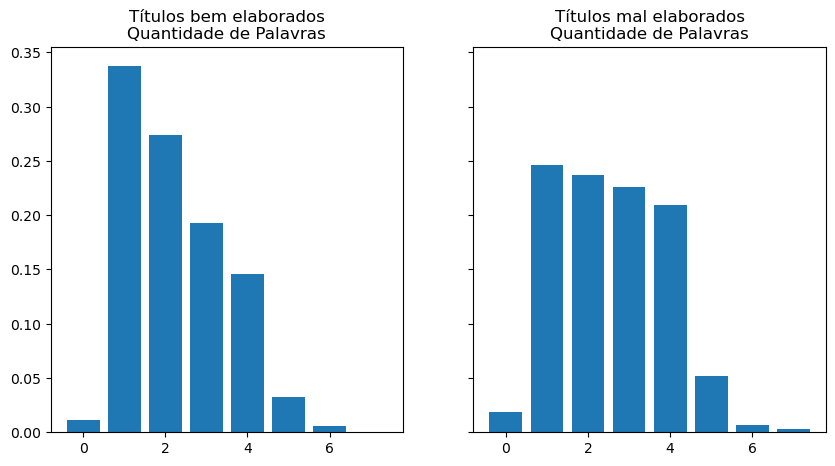

In [27]:
t_bem_elaborados = df_items[df_items['titulo_bem_elaborado']==1]['tokens']
t_mal_elaborados = df_items[df_items['titulo_bem_elaborado']==0]['tokens']

len_t_bem_elaborados = [len(doc) for doc in t_bem_elaborados]
len_t_mal_elaborados = [len(doc) for doc in t_mal_elaborados]

bins = [0,5,10,15,20,25,30,35,50]
h_len_t_bem_elaborados,_ = np.histogram(len_t_bem_elaborados,bins=bins)
h_len_t_mal_elaborados,_ = np.histogram(len_t_mal_elaborados,bins=bins)

h_len_t_bem_elaborados=h_len_t_bem_elaborados/h_len_t_bem_elaborados.sum()
h_len_t_mal_elaborados=h_len_t_mal_elaborados/h_len_t_mal_elaborados.sum()

fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
x=range(len(bins)-1)
ax[0].bar(x,h_len_t_bem_elaborados)
ax[0].set_title('Títulos bem elaborados\nQuantidade de Palavras')
ax[1].bar(x,h_len_t_mal_elaborados)
ax[1].set_title('Títulos mal elaborados\nQuantidade de Palavras')

plt.show()

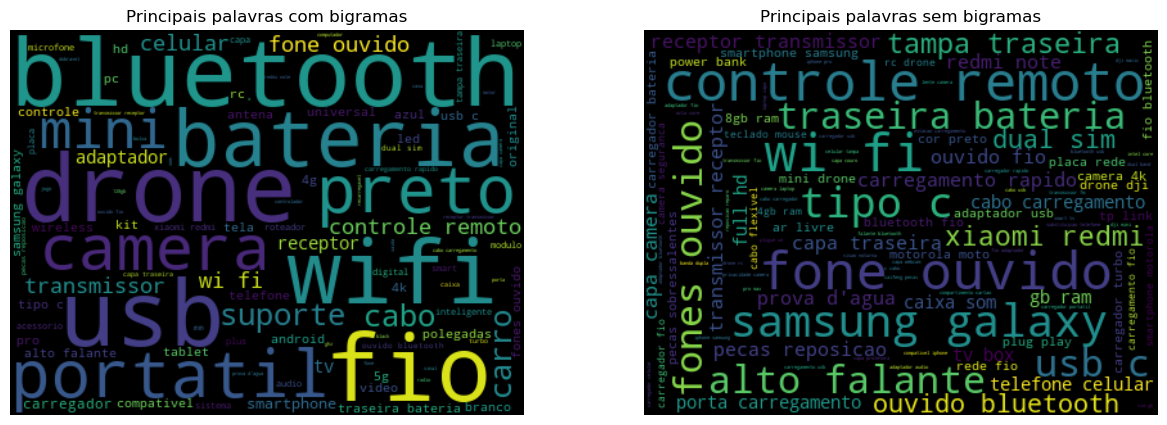

In [28]:
from functions import plot_wordcloud

f_t_bem_elaborados = [token for row in t_bem_elaborados for token in row]
f_t_mal_elaborados = [token for row in t_mal_elaborados for token in row]

plot_wordcloud(f_t_bem_elaborados,100)

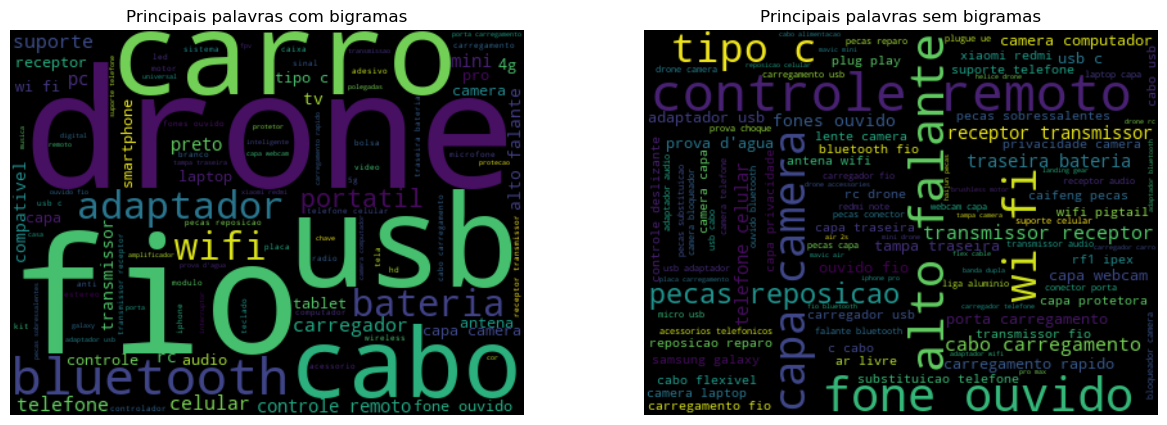

In [29]:
plot_wordcloud(f_t_mal_elaborados,100)

### Produtos passíveis de homologação vs não passíveis

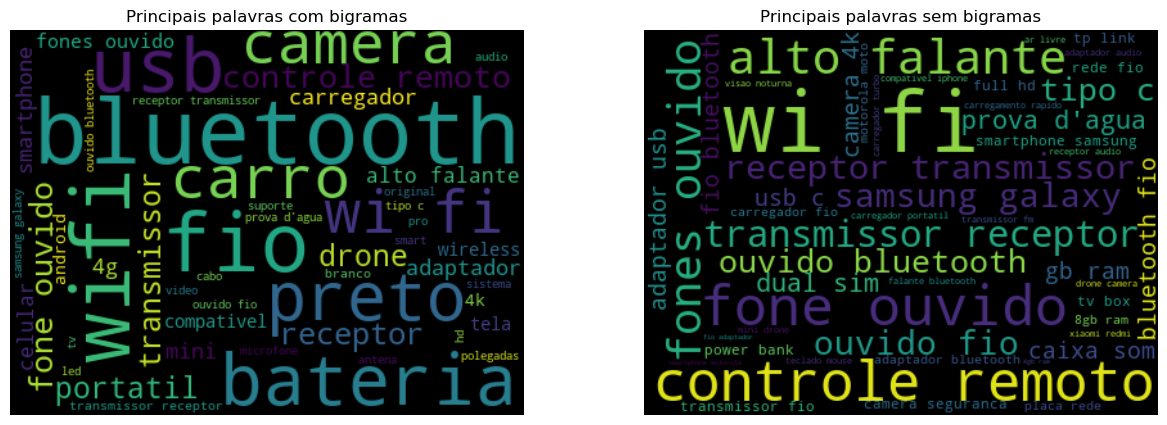

In [30]:
t_passiveis = df_items[df_items['passivel_homologacao']==1]['doc']
t_nao_passiveis = df_items[df_items['passivel_homologacao']==0]['doc']

plot_wordcloud(t_passiveis)

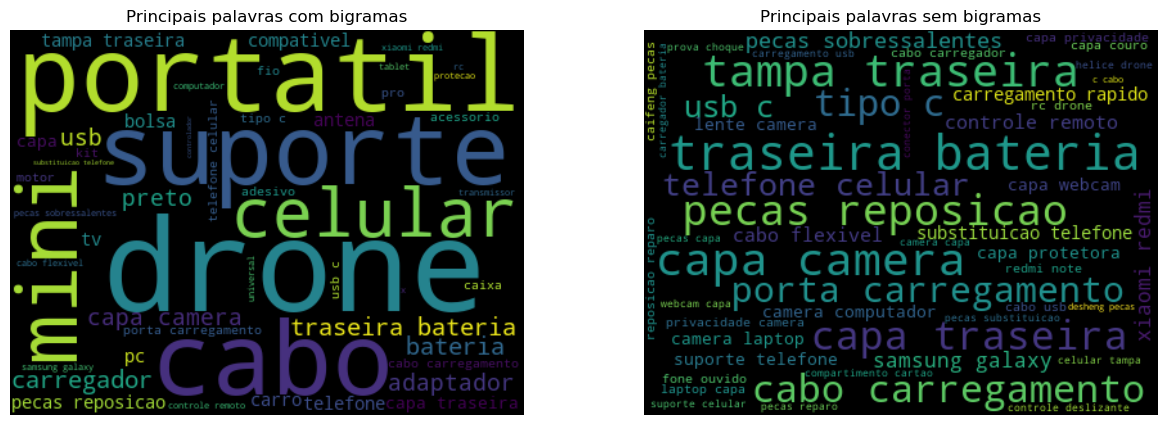

In [31]:
plot_wordcloud(t_nao_passiveis)

### Transmissores de rf vs não transmissores

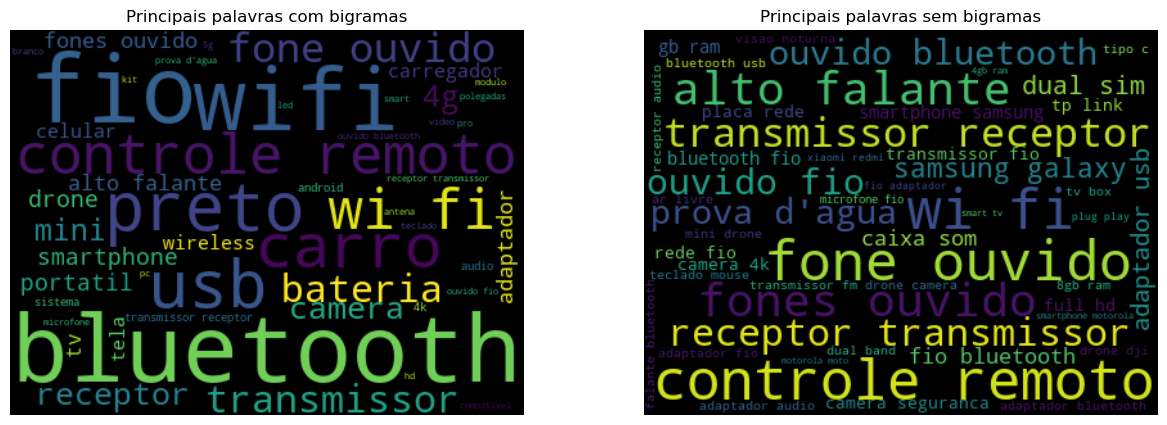

In [32]:
t_transmissor_rf = df_items[df_items['transmissor_rf']==1]['doc']
t_nao_transmissor_rf = df_items[df_items['transmissor_rf']==0]['doc']

plot_wordcloud(t_transmissor_rf)

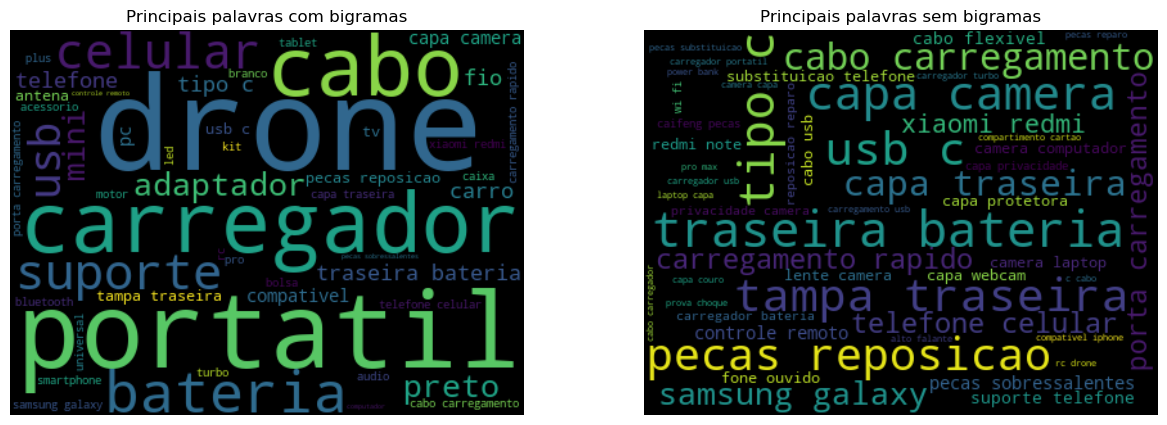

In [33]:
plot_wordcloud(t_nao_transmissor_rf)